# MSIN0143 Coursework Group Q2

# Building an Analytical Notebook in Python

Predicting Taiwan Semiconductor Manufacturing Company Stock (NYSE: TSM) using historical stock data

21073058 Daniel Silalahi
Insert SN Name
Insert SN Name
Insert SN Name

Word Count: XXXX


# Background Information

*   TSMC Company
*   Why TSMC: talk about use of AI, need for high-powered semiconductors
*   More Context
*   Why other companies stock prices also (Nvidia, S&P 500, Taiwan Index)

Since we need GenAI component, we can say that ChatGPT suggested Nvidia, s&p etc. for various reasons (e.g. partnership, overall economic indicators etc.)

In [ ]:
# Downloading Necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from statsmodels.tsa.api import VAR
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Here we import data from yfinance

It is important to keep most of the data, as some missing values in one stock may not mean that other stocks have those missing values.



In [ ]:
# Import TSM (Taiwan Semiconductor Manufacturing Company), NVDA (Nvidia), TAIEX (Taiwan Stock Index), and .INX (US S&P 500 Index)

# Create a list of stock tickers
tickers = ["TSM",   # Taiwan Semiconductor Manufacturing Company
           "NVDA",  # Nvidia
           "^TWII", # Taiwan Stock Exchange Index
           "^GSPC"] # S&P 500

# Fetch historical data from Yahoo Finance
data = yf.download(tickers, start='2014-12-01', end='2024-12-01')

# Align all stock data to closing time for consistency
data = data['Adj Close']
data = data.sort_index()  # Sort by date
data.columns = ["TSM", "NVDA", "TAIEX", "S&P 500"] # Rename columns

# Show data head
data.head()

[*********************100%***********************]  4 of 4 completed


,TSM,NVDA,TAIEX,S&P 500
Date,,,,
2014-12-01 00:00:00+00:00,0.493978,17.410347,2053.439941,9117.667969
2014-12-02 00:00:00+00:00,0.494698,17.129534,2066.550049,9034.749023
2014-12-03 00:00:00+00:00,0.507420,17.402758,2074.330078,9175.217773
2014-12-04 00:00:00+00:00,0.502859,17.319269,2071.919922,9225.068359
2014-12-05 00:00:00+00:00,0.505740,17.258553,2075.370117,9206.528320


It is important to keep most of the data, as some missing values in one stock may not mean that other stocks have those missing values. Before we choose a method to interpolate missing data, we need to find out the average missing percentage and average time between missing values. For example, we could use a forward or linear fill to fill data if there is a low average time between missing values, meaning that the missing values are spread throughout. But a more complex method with moving averages may be needed if there are large gaps

In [ ]:
# Checking for missing values
missing_values = data.isna().sum().sum()
total_values = data.size
missing_percentage = (missing_values / total_values) * 100
print(missing_percentage)

# Check for average number of days between missing values

# Firstly, identify missing values
missing_dates = data.isna()
# Create a list of missing gaps, where each value is the number of days between valid data
missing_gaps = []

# Iterate over dataset
i = 0
while i < len(data):
    # Check if the current day is missing
    if missing_dates.iloc[i].any():
        missing_count = 1  # Start counting the missing day
        # Iterate over the next days until we find a valid day
        while i + 1 < len(data) and missing_dates.iloc[i + 1].any():
            missing_count += 1
            i += 1
        # After finding a valid day, store the gap (number of missing days)
        missing_gaps.append(missing_count)
    i += 1

average_gap = sum(missing_gaps) / len(missing_gaps)
print(f"Average number of consecutive missing days: {average_gap}")

3.8342967244701347
Average number of consecutive missing days: 1.5316455696202531


Because average distance is only 1.53 days, we have chosen to move forward with linear fill, as it allows more insight than forward fill by bridging the missing gap bewteen valid data

In [ ]:
# Data Cleaning
# Interpolate missing values
data = data.interpolate(method='linear')

# Exploratory Data Analysis

Firstly, we plot stock prices over time...cont...

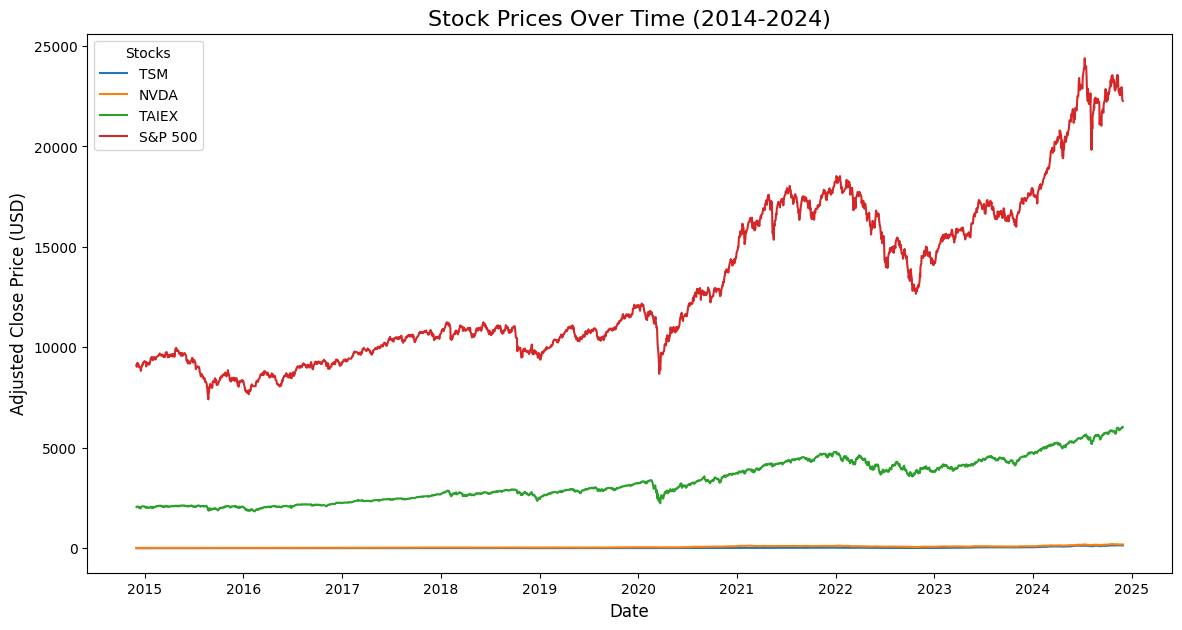

In [ ]:
# Plot the stock prices over time
plt.figure(figsize=(14, 7))

for column in data.columns:
    plt.plot(data.index, data[column], label=column)

# Add title and labels
plt.title('Stock Prices Over Time (2014-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)

# Add legend and show plot
plt.legend(title="Stocks", fontsize=10)
plt.show()

However, we can see that very large difference, making it hard to view any relationships. Therefore, to improve legibility, we will use min-max scaling to normalise the data across columns. This will also make it easier for the model to gauge relationships across independent variables (counts as feature engineering), as well as allowing us to better analyse the coefficients of models later on.

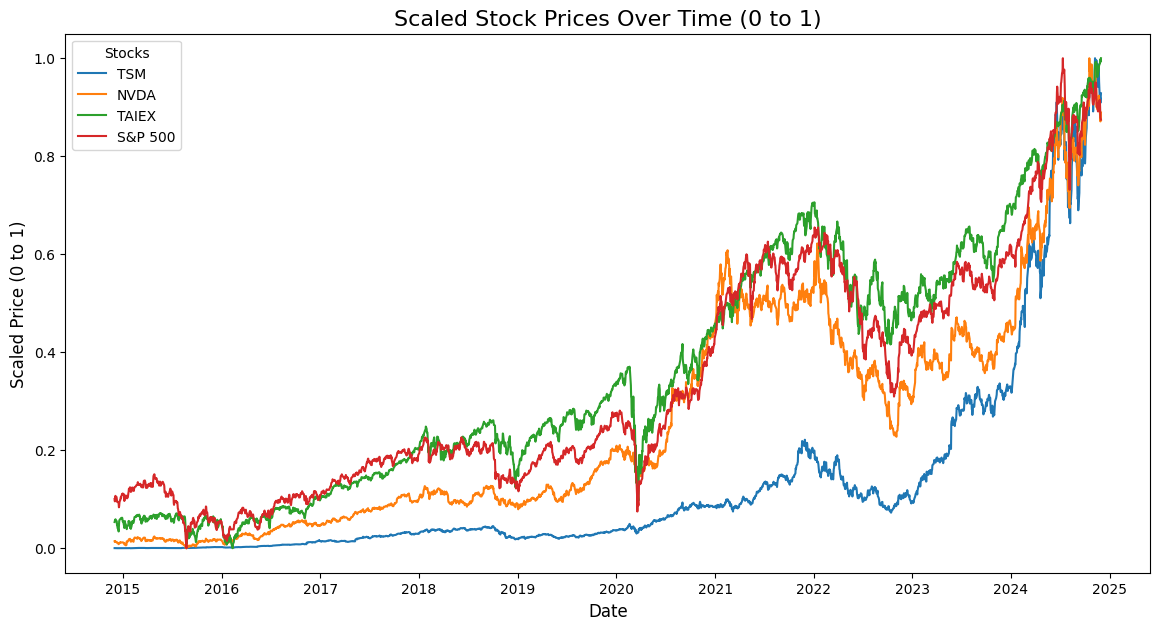

In [ ]:
# Initialise scaler
scaler = MinMaxScaler()

# Scale data, ensuring that we scale per column and not as a whole
scaled_data = scaler.fit_transform(data.values)

# Create a new scaled dataframe
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

# Create plot
plt.figure(figsize=(14, 7))

for column in scaled_df.columns:
    plt.plot(scaled_df.index, scaled_df[column], label=column)

plt.title('Scaled Stock Prices Over Time (0 to 1)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Scaled Price (0 to 1)', fontsize=12)

plt.legend(title="Stocks", fontsize=10)
plt.show()

Write description of data...better for model analysis as well as visualisations in terms of legibility as compared to percentage growth/change and coefficient analysis

Furthermore, we can also conduct feature engineering on the scaled dataset by converting it into percentage growth to discover trends in growth over time

In [ ]:
# Convert Scaled data into percentage data
growth_df = data.pct_change() * 100

# Drop NA values as first and last day will not have growth data
growth_df.dropna(inplace=True)

                                TSM      NVDA     TAIEX   S&P 500
Date                                                             
2014-12-02 00:00:00+00:00  0.145797 -1.612910  0.638446 -0.909432
2014-12-03 00:00:00+00:00  2.571612  1.595046  0.376474  1.554761
2014-12-04 00:00:00+00:00 -0.898804 -0.479743 -0.116190  0.543318
2014-12-05 00:00:00+00:00  0.572792 -0.350573  0.166522 -0.200975
2014-12-08 00:00:00+00:00 -1.281435 -1.055385 -0.725657 -0.209420


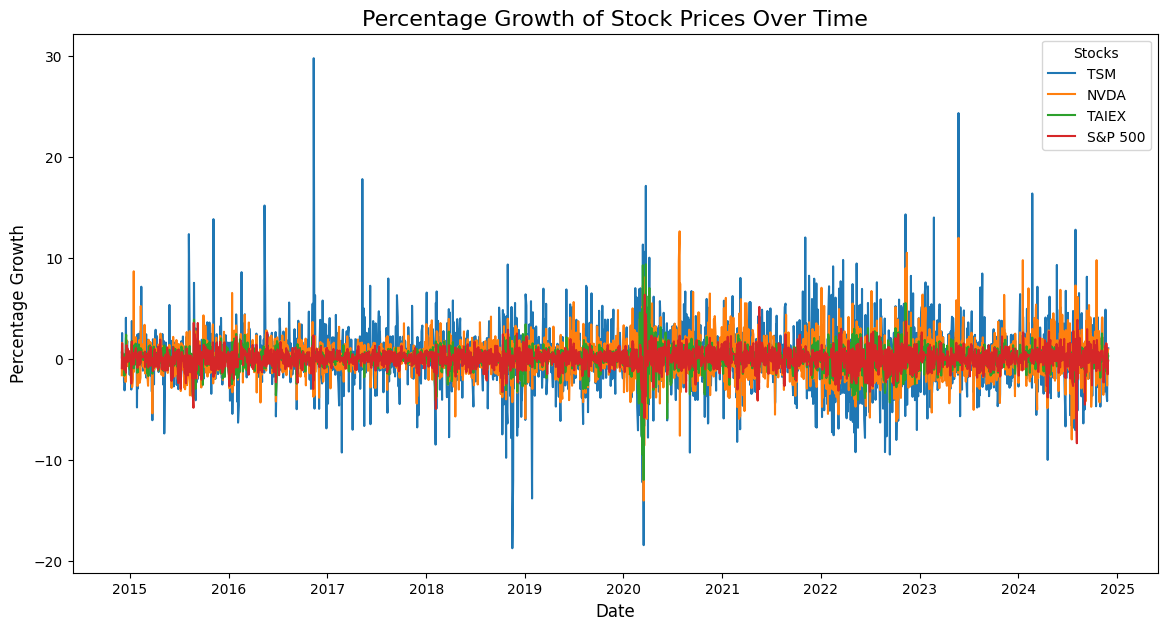

In [ ]:
# Display the first few rows of the growth DataFrame
print(growth_df.head())

# Plot the percentage growth data
plt.figure(figsize=(14, 7))

for column in growth_df.columns:
    plt.plot(growth_df.index, growth_df[column], label=column)

plt.title('Percentage Growth of Stock Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Growth', fontsize=12)

plt.legend(title="Stocks", fontsize=10)
plt.show()

Description of graph above

               TSM         NVDA        TAIEX      S&P 500
count  2594.000000  2594.000000  2594.000000  2594.000000
mean      0.261651     0.110122     0.047608     0.038967
std       2.990879     1.956378     1.098220     0.952059
min     -18.755883   -14.034062   -11.984055    -8.351980
25%      -1.183236    -0.925033    -0.358334    -0.402289
50%       0.253720     0.078642     0.054201     0.085508
75%       1.704492     1.068566     0.559971     0.538112
max      29.806735    12.652218     9.382774     6.367105


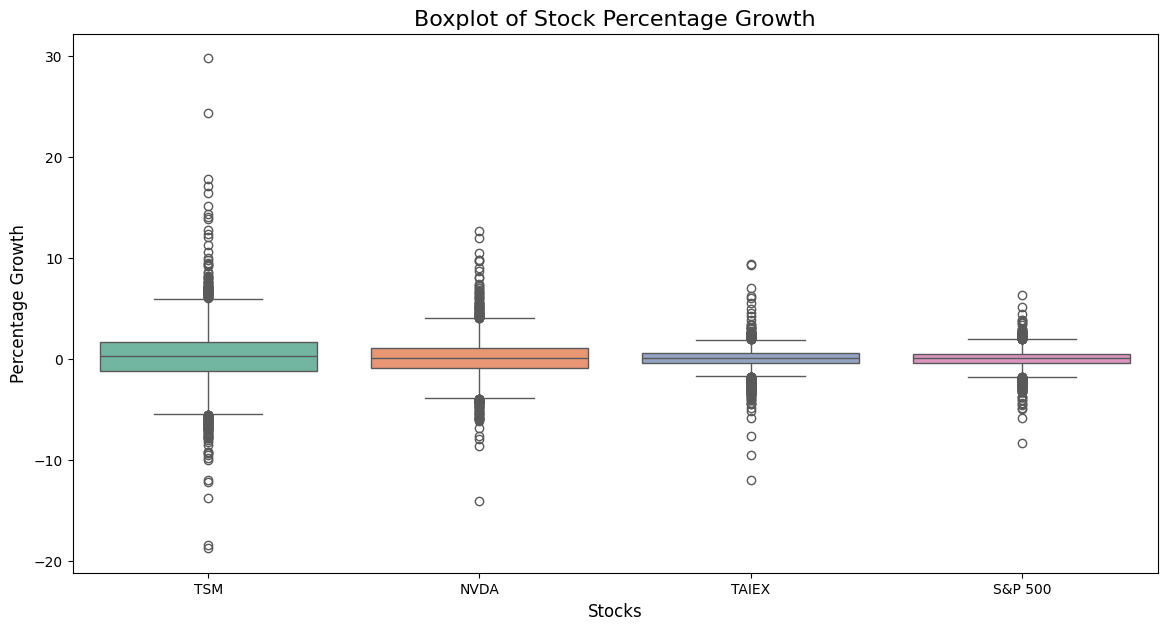

In [ ]:
# Summary of dataframe

# Generate summary statistics for the growth_df (percentage growth)
growth_summary = growth_df.describe()
print(growth_summary)

# Create a boxplot
plt.figure(figsize=(14, 7))

sns.boxplot(data=growth_df, palette='Set2')

plt.title('Boxplot of Stock Percentage Growth', fontsize=16)
plt.xlabel('Stocks', fontsize=12)
plt.ylabel('Percentage Growth', fontsize=12)

plt.show()

Explanation of summary statistics. Summary statistics of growth was chosen instead of the scaled data as scaled data always rises and there is no valuable statistical insight from this...

Description of boxplot. Explanation of why we wont remove outliers (Stock price is known to be very impacted by general public perception and other factors, wide swings in price are very common etc.)

Furthermore, we will create a correlation matrix to explore relationships between variables, check for multicollinearity, and provide insight for feature selection

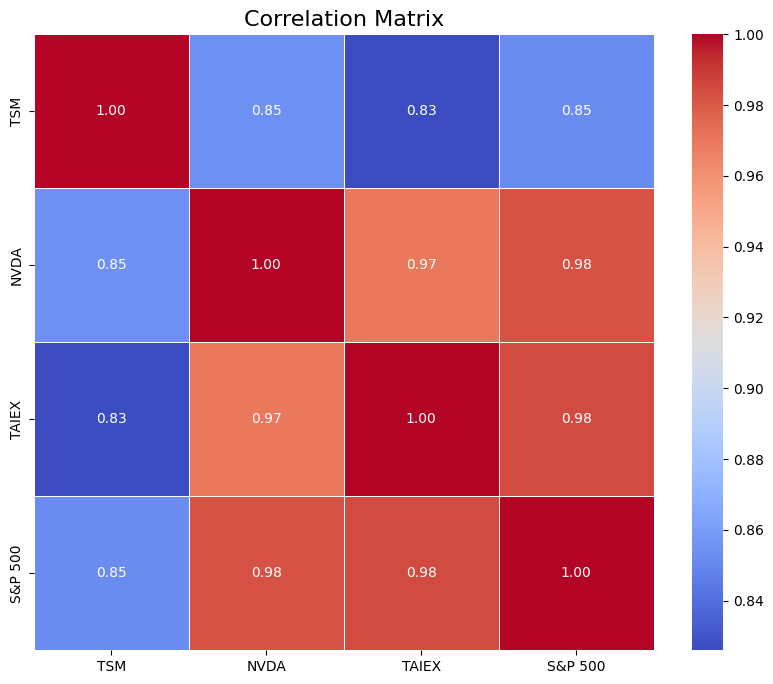

In [ ]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Explanation of Correlation matrix, we decide to keep NVDA, TAIEX, and S&P as they indicate a strong positive relationship.

Other variables exhibit multicollinearity, however (insert reason to keep them as stock prices move as a whole market usually etc)

# Model Selection and Training

We have chosen to move forward with LSTM and ARIMA model, as these are both time series models etc.

Training will also include TSM as a predictor, this is popular with stock prediction etc (include source)

Explain brief steps of model
- TSM, NVDA, S&P... used as predictor for future TSM results

Also include GenAI component here to determine models

Firstly, we need to create a single step sampler function

Sourced used for coding:
https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [ ]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
              # Features for each column
              r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df['TSM'].iloc[i + window])  # Target is TSM
    return np.array(xRes), np.array(yRes)

Below we split the data into test and training groups (insert source on why 85:15 split is good for stock data)

In [ ]:
# Define the time window for LSTM
window_size = 20

# Prepare the dataset using the singleStepSampler function
xVal, yVal = singleStepSampler(scaled_df, window_size)

# Split the dataset using train_test_split
# Shuffle is set as false as it is a time series data
X_train, X_test, y_train, y_test = train_test_split(xVal, yVal, test_size=0.15, random_state=42, shuffle=False)

<ipython-input-25-928a42128651>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r.append(df[col][i + j])


Define and Train LSTM Model

In [ ]:
# Define LSTM model using default parameters
multivariate_lstm = Sequential([
    LSTM(128, activation='tanh', input_shape=(window_size, X_train.shape[2])),
    Dense(1)  # However, we need to tweak this paramater as we need it for our continuous data
])

# Set at default values as per brief
multivariate_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = multivariate_lstm.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0, verbose=1)

# Predict
predicted_values = multivariate_lstm.predict(X_test)

# Reload the data with the date index
scaled_df.index = pd.to_datetime(scaled_df.index)

# Create a dataframe of predictions and actuals
d = {
    'Predicted Price': predicted_values.flatten(),
    'Actual Price': y_test,
}
d = pd.DataFrame(d)
d.index = scaled_df.index[-len(y_test):]  # Assigning the correct date index

# Convert scaled data back to actual prices

# Align y_test (Scaled TSM) indicies with actual TSM indicies to figure out ratio
actual_close_prices = data['TSM'].iloc[-len(y_test):].values
ratios = actual_close_prices / y_test

# Apply ratios to d
d['Predicted Price'] = d['Predicted Price'] * ratios
d['Actual Price'] = d['Actual Price'] * ratios

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0010
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Plotting LSTM Model

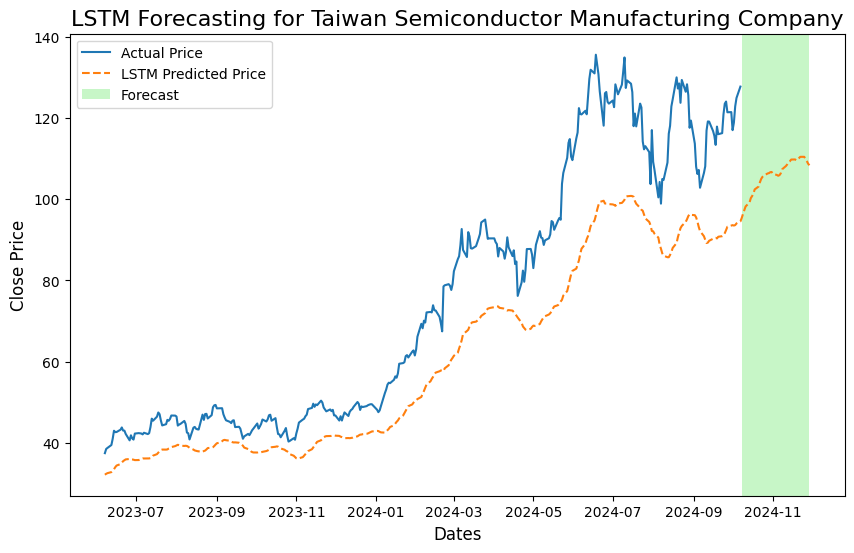

In [ ]:
# Plot forecast with Dates on X-axis
fig, ax = plt.subplots(figsize=(10, 6))

highlight_start = int(len(d) * 0.9)  # Highlight 10% for forecasting
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d['Actual Price'][:highlight_start], label='Actual Price')

# Plot predicted values with a dashed line
plt.plot(d['Predicted Price'], label='LSTM Predicted Price', linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('LSTM Forecasting for Taiwan Semiconductor Manufacturing Company', fontsize=16)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
ax.legend()
plt.show()

Interpretation of model. Talk about how we rescaled the data for better legibility (dont worry about the model looking bad, it is because as per coursework brief, we need to use default parameters)

Multivariate ARIMA model (Vector Autoregression)

Code Sourced from : https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
https://www.geeksforgeeks.org/vector-autoregression-var-for-multivariate-time-series/
https://www.cloudzilla.ai/dev-education/multivariate-time-series-using-auto-arima/#understanding-the-arima-model
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#Dealing_With_a_Multivariate_Time_Series_%E2%80%93_VAR

Splitting into training and test sets as well as scaling as VAR needs stationary data

In [ ]:
data_diff = scaled_df.diff()

# Splitting
train_size = int(len(scaled_df) * 0.85)  # 85% for training, 15% for testing
train_data, test_data = scaled_df[:train_size], scaled_df[train_size:]

Define and train ARIMA model

In [ ]:
# Define VAR model with default parameters
model = VAR(train_data)
# Fit the VAR model using default parameters
results = model.fit()

# Predict using the fitted model
predicted = results.forecast(train_data.values[-results.k_ar:], steps=len(test_data))

# Convert forecast to DataFrame
predicted_df = pd.DataFrame(predicted, index=test_data.index, columns=test_data.columns)

# Prepare data for plotting (comparing predicted vs actual)
d_var = {
    'Predicted Price': predicted_df['TSM'],  # Using 'TSM' as the variable to forecast
    'Actual Price': test_data['TSM']
}

d_var = pd.DataFrame(d_var)
d_var.index = test_data.index  # Ensure correct Date index

# Reverse the differencing
d_var['Predicted Price'] = np.cumsum(d_var['Predicted Price'].values, axis=0)
d_var['Actual Price'] = np.cumsum(d_var['Actual Price'].values, axis=0)

# Rescale the data (as data is scaled) as previously done
actual_prices = data['TSM'].iloc[-len(d_var):].values
ratios = actual_prices / d_var['Actual Price'].values

# Apply ratios to d
d_var['Predicted Price'] = d_var['Predicted Price'] * ratios
d_var['Actual Price'] = d_var['Actual Price'] * ratios

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Plot ARIMA/VAR

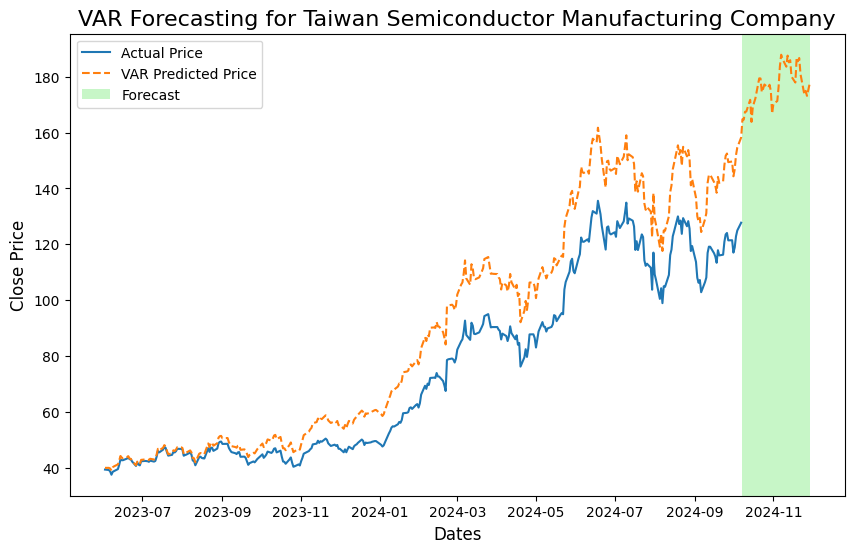

In [ ]:
# Plot forecast with Dates on X-axis
fig, ax = plt.subplots(figsize=(10, 6))

highlight_start = int(len(d_var) * 0.9)  # Highlight 10% for forecasting
highlight_end = len(d_var) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d_var['Actual Price'][:highlight_start], label='Actual Price')

# Plot predicted values with a dashed line
plt.plot(d_var['Predicted Price'], label='VAR Predicted Price', linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d_var.index[highlight_start], d_var.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('VAR Forecasting for Taiwan Semiconductor Manufacturing Company', fontsize=16)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
ax.legend()
plt.show()

Interpretation of model. Talk about how we rescaled again etc.

# Performance Evaluation

LSTM Evaluation

In [ ]:
# Evaluate the performance of the model
def eval(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

result = eval(d['Actual Price'], d['Predicted Price'])
print("Evaluation Results:", result)

Evaluation Results: {'MSE': 409.0055098659443, 'MAE': 17.00414825813548, 'R2': 0.6828523852630664}


Interpretation of results.

If anyone is up to it try do coefficient analysis/feature importance, i tried but couldnt do it


ARIMA Evaluation

In [ ]:
# Key statistics of performance
def eval(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)

    }

result_var = eval(d_var['Actual Price'], d_var['Predicted Price'])
print("Evaluation Results:", result_var)

Evaluation Results: {'MSE': 370.54944267957075, 'MAE': 15.772904450429992, 'R2': 0.7136231504853691}


Interpretation of key statistics. If anyone is up to it try do coefficient analysis/feature importance, i tried but couldnt do it

# Conclusion

In conclusion...

For further research, we could optimise the hyperparameters using grid search or random search (https://medium.com/@hestisholihah01/hyperparameter-tuning-showdown-grid-search-vs-random-search-which-is-the-ultimate-winner-5927b322e54d)

Also include GenAI component here